In [2]:
%cd ../modules/dasgupta

/home/kateryna_akhynko/NYU/xAI-Ranking-Benchmark/modules/dasgupta


In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import check_random_state

from dasgupta import box_plot_competing_power3 as box_plot
from dasgupta import shapley_values, competing_powers, competing_powers2

# Datasets

In [96]:
RNG_SEED = 42
N_SAMPLES = 200
rng = check_random_state(RNG_SEED)

In [97]:
X1 = rng.normal(loc=0, scale=1, size=N_SAMPLES)
Y1 = rng.uniform(low=-1, high=1, size=N_SAMPLES)

In [98]:
data1 = {'X': X1, 'Y': Y1}
df1 = pd.DataFrame(data1)
df1[[x for x in df1.columns]] = MinMaxScaler().fit_transform(df1[[x for x in df1.columns]])

In [99]:
correlation_coefficient = 0.7

Z1 = correlation_coefficient * X1 + rng.normal(loc=0, scale=np.sqrt(1 - correlation_coefficient**2), size=N_SAMPLES)

data1_cor = {'X': X1, 'Y': Y1, 'Z': Z1}
df1_cor = pd.DataFrame(data1_cor)
df1_cor[[x for x in df1.columns]] = MinMaxScaler().fit_transform(df1_cor[[x for x in df1.columns]])

In [100]:
X2 = rng.normal(loc=9, scale=16, size=N_SAMPLES)
Y2 = rng.uniform(low=-5, high=6, size=N_SAMPLES)

In [101]:
data2 = {'X': X2, 'Y': Y2}
df2 = pd.DataFrame(data2)
df2[[x for x in df2.columns]] = MinMaxScaler().fit_transform(df2[[x for x in df2.columns]])

In [102]:
correlation_coefficient = 0.7

Z2 = correlation_coefficient * X2 + rng.normal(loc=0, scale=np.sqrt(1 - correlation_coefficient**2), size=N_SAMPLES)

data2_cor = {'X': X2, 'Y': Y2, 'Z': Z2}
df2_cor = pd.DataFrame(data2_cor)
df2_cor[[x for x in df2_cor.columns]] = MinMaxScaler().fit_transform(df2_cor[[x for x in df2_cor.columns]])

## Ranking functions

In [103]:
two_vars_equal = {"X": 0.5, "Y":0.5, "Z":0}

In [104]:
two_vars_non_equal = {"X": 0.7, "Y":0.3, "Z":0}

In [105]:
three_vars_equal = {"X": 0.33, "Y":0.33, "Z":0.33}

In [106]:
three_vars_non_equal = {"X": 0.4, "Y":0.4, "Z":0.2}

In [107]:
equal_weights = np.array([0.5, 0.5])
equal_weights_z = np.array([0.5, 0.5, 0])
equal_weights_three = np.array([0.33, 0.33, 0.33])

In [108]:
different_weights = np.array([0.7, 0.3])
different_weights_z = np.array([0.7, 0.3, 0])
different_weights_three = np.array([0.4, 0.4, 0.2])

# Comparison

## Dasgupta

### Single batch

In [115]:
rank_range_upper = 1
rank_range_lower = N_SAMPLES
exponential_attention = 5

In [116]:
results = pd.DataFrame(columns=["mean", "std", "shapley_type", "feature", "strata", "batch", "qoi", "weights", "data", "group"])

#### No correlation

In [117]:
for df_index, df in enumerate([df1, df2]):
    for weights_index, weights in enumerate([two_vars_equal, two_vars_non_equal]):
        df_copy = df.copy()

        half_samples = len(df_copy) // 2
        df_copy['Group'] = (np.concatenate((np.zeros(half_samples), np.ones(len(df_copy) - half_samples)))).astype(int)
        df_copy['Group'] = df_copy['Group'].sample(frac=1, random_state=10).values

        df_copy["N"] = np.ones(len(df_copy))
        num_batches = 1
        
        df_copy['score'] = weights['X']*df_copy['X'] + weights['Y']*df_copy['Y']
        df_copy['rank'] = (df_copy['score'].rank()).astype(int)
        
        score_vars = ["X", "Y"]
        
        # Shapley values
        df_mean_shap, df_mean_shap_privileged, df_mean_shap_protected = shapley_values(
            df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
        )
        
        mean1 = df_mean_shap.mean(axis=1)
        std1 = df_mean_shap.std(axis=1)
        
        # Standardized Shapley values
        (
        df_mean_compete,
        df_mean_compete_privileged,
        df_mean_compete_protected,
        ) = competing_powers(
            df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
        )
        mean2 = df_mean_compete.mean(axis=1)
        std2 = df_mean_compete.std(axis=1)
        
        # Rank-relevance Shapley values
        (
            df_mean_compete2,
            df_mean_compete_privileged2,
            df_mean_compete_protected2,
        ) = competing_powers2(
            df_copy,
            weights,
            rank_range_upper,
            rank_range_lower,
            score_vars,
            num_batches,
            exponential=exponential_attention,
        )
        mean3 = df_mean_compete2.mean(axis=1)
        std3 = df_mean_compete2.std(axis=1)
        
        if weights_index == 1:
            weights_name= "different weights"
        else:
            weights_name = "equal weights"
        
        strata_name = "0-100%"
        batch_name= None
        qoi_name = None
        group_name= "NONE"
    
        if df_index == 0:
            data_name= "Standard normal 2 vars"
        else:
            data_name= "Arbitrary normal 2 vars"
            
        results.loc[len(results.index)] = [mean1["X_contri"], std1["X_contri"], "shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean1["Y_contri"], std1["Y_contri"], "shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        
        results.loc[len(results.index)] = [mean2["X_contri"], std2["X_contri"], "standardized shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean2["Y_contri"], std2["Y_contri"], "standardized shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        
        results.loc[len(results.index)] = [mean3["X_contri"], std3["X_contri"], "rank-relevance shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean3["Y_contri"], std3["Y_contri"], "rank-relevance shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]

#### Correlation

In [118]:
for df_index, df in enumerate([df1_cor, df2_cor]):
    for weights_index, weights in enumerate([two_vars_equal, two_vars_non_equal, three_vars_equal, three_vars_non_equal]):
        df_copy = df.copy()

        half_samples = len(df_copy) // 2
        df_copy['Group'] = (np.concatenate((np.zeros(half_samples), np.ones(len(df_copy) - half_samples)))).astype(int)
        df_copy['Group'] = df_copy['Group'].sample(frac=1, random_state=10).values

        df_copy["N"] = np.ones(len(df_copy))
        num_batches = 1
        
        df_copy['score'] = weights['X']*df_copy['X'] + weights['Y']*df_copy['Y'] + weights['Z']*df_copy['Z']
        df_copy['rank'] = (df_copy['score'].rank()).astype(int)
        
        score_vars = ["X", "Y", "Z"]
        
        # Shapley values
        df_mean_shap, df_mean_shap_privileged, df_mean_shap_protected = shapley_values(
            df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
        )
        
        mean1 = df_mean_shap.mean(axis=1)
        std1 = df_mean_shap.std(axis=1)
        
        # Standardized Shapley values
        (
        df_mean_compete,
        df_mean_compete_privileged,
        df_mean_compete_protected,
        ) = competing_powers(
            df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
        )
        mean2 = df_mean_compete.mean(axis=1)
        std2 = df_mean_compete.std(axis=1)
        
        # Rank-relevance Shapley values
        (
            df_mean_compete2,
            df_mean_compete_privileged2,
            df_mean_compete_protected2,
        ) = competing_powers2(
            df_copy,
            weights,
            rank_range_upper,
            rank_range_lower,
            score_vars,
            num_batches,
            exponential=exponential_attention,
        )
        mean3 = df_mean_compete2.mean(axis=1)
        std3 = df_mean_compete2.std(axis=1)
        
        if weights_index in [1, 3]:
            weights_name= "different weights"
        else:
            weights_name = "equal weights"
        
        strata_name = "0-100%"
        batch_name= None
        qoi_name = None
        group_name= "NONE"
    
        if df_index == 0:
            if weights_index in [0, 1]:
                data_name= "Standard normal 2 vars with correlated third"
            else:
                data_name= "Standard normal 3 correlated vars"
        else:
            if weights_index in [0, 1]:
                data_name= "Arbitrary normal 2 vars with correlated third"
            else:
                data_name= "Arbitrary normal 3 correlated vars"
            
        results.loc[len(results.index)] = [mean1["X_contri"], std1["X_contri"], "shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean1["Y_contri"], std1["Y_contri"], "shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean1["Z_contri"], std1["Z_contri"], "shapley value", "Z", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        
        results.loc[len(results.index)] = [mean2["X_contri"], std2["X_contri"], "standardized shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean2["Y_contri"], std2["Y_contri"], "standardized shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean2["Z_contri"], std2["Z_contri"], "standardized shapley value", "Z", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        
        results.loc[len(results.index)] = [mean3["X_contri"], std3["X_contri"], "rank-relevance shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean3["Y_contri"], std3["Y_contri"], "rank-relevance shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
        results.loc[len(results.index)] = [mean3["Z_contri"], std3["Z_contri"], "rank-relevance shapley value", "Z", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]

### Strata (no batches) comparison

In [119]:
exponential_attention = 5

#### No correlation

In [120]:
for df_index, df in enumerate([df1, df2]):
    for weights_index, weights in enumerate([two_vars_equal, two_vars_non_equal]):
        for rank_range_upper, rank_range_lower in zip([1, 41, 81, 141, 181], [40, 80, 120, 160, 200]):
            df_copy = df.copy()

            half_samples = len(df_copy) // 2
            df_copy['Group'] = (np.concatenate((np.zeros(half_samples), np.ones(len(df_copy) - half_samples)))).astype(int)
            df_copy['Group'] = df_copy['Group'].sample(frac=1, random_state=10).values

            df_copy["N"] = np.ones(len(df_copy))
            num_batches = 1
            
            df_copy['score'] = weights['X']*df_copy['X'] + weights['Y']*df_copy['Y']
            df_copy['rank'] = (df_copy['score'].rank()).astype(int)
            
            score_vars = ["X", "Y"]
            
            # Shapley values
            df_mean_shap, df_mean_shap_privileged, df_mean_shap_protected = shapley_values(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
        
            mean1 = df_mean_shap.mean(axis=1)
            std1 = df_mean_shap.std(axis=1)
            
            # Standardized Shapley values
            (
            df_mean_compete,
            df_mean_compete_privileged,
            df_mean_compete_protected,
            ) = competing_powers(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            mean2 = df_mean_compete.mean(axis=1)
            std2 = df_mean_compete.std(axis=1)
            
            # Rank-relevance Shapley values
            (
                df_mean_compete2,
                df_mean_compete_privileged2,
                df_mean_compete_protected2,
            ) = competing_powers2(
                df_copy,
                weights,
                rank_range_upper,
                rank_range_lower,
                score_vars,
                num_batches,
                exponential=exponential_attention,
            )
            mean3 = df_mean_compete2.mean(axis=1)
            std3 = df_mean_compete2.std(axis=1)
        
            if weights_index == 1:
                weights_name= "different weights"
            else:
                weights_name = "equal weights"
            
            if rank_range_upper == 1:
                strata_name = "0-20%"
            elif rank_range_upper == 41:
                strata_name = "20-40%"
            elif rank_range_upper == 81:
                strata_name = "40-60%"
            elif rank_range_upper == 141:
                strata_name = "60-80%"
            elif rank_range_upper == 181:
                strata_name = "80-100%"
            
            batch_name= None
            qoi_name = None
            group_name= "NONE"
        
            if df_index == 0:
                data_name= "Standard normal 2 vars"
            else:
                data_name= "Arbitrary normal 2 vars"
                
            results.loc[len(results.index)] = [mean1["X_contri"], std1["X_contri"], "shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean1["Y_contri"], std1["Y_contri"], "shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            
            results.loc[len(results.index)] = [mean2["X_contri"], std2["X_contri"], "standardized shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean2["Y_contri"], std2["Y_contri"], "standardized shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            
            results.loc[len(results.index)] = [mean3["X_contri"], std3["X_contri"], "rank-relevance shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean3["Y_contri"], std3["Y_contri"], "rank-relevance shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]

#### Correlation

In [121]:
for df_index, df in enumerate([df1_cor, df2_cor]):
    for weights_index, weights in enumerate([two_vars_equal, two_vars_non_equal, three_vars_equal, three_vars_non_equal]):
        for rank_range_upper, rank_range_lower in zip([1, 41, 81, 141, 181], [40, 80, 120, 160, 200]):
            df_copy = df.copy()

            half_samples = len(df_copy) // 2
            df_copy['Group'] = (np.concatenate((np.zeros(half_samples), np.ones(len(df_copy) - half_samples)))).astype(int)
            df_copy['Group'] = df_copy['Group'].sample(frac=1, random_state=10).values

            df_copy["N"] = np.ones(len(df_copy))
            num_batches = 1
            
            df_copy['score'] = weights['X']*df_copy['X'] + weights['Y']*df_copy['Y'] + weights['Z']*df_copy['Z']
            df_copy['rank'] = (df_copy['score'].rank()).astype(int)
            
            score_vars = ["X", "Y", "Z"]
            
            # Shapley values
            df_mean_shap, df_mean_shap_privileged, df_mean_shap_protected = shapley_values(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            
            mean1 = df_mean_shap.mean(axis=1)
            std1 = df_mean_shap.std(axis=1)
            
            # Standardized Shapley values
            (
            df_mean_compete,
            df_mean_compete_privileged,
            df_mean_compete_protected,
            ) = competing_powers(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            mean2 = df_mean_compete.mean(axis=1)
            std2 = df_mean_compete.std(axis=1)
        
            # Rank-relevance Shapley values
            (
                df_mean_compete2,
                df_mean_compete_privileged2,
                df_mean_compete_protected2,
            ) = competing_powers2(
                df_copy,
                weights,
                rank_range_upper,
                rank_range_lower,
                score_vars,
                num_batches,
                exponential=exponential_attention,
            )
            mean3 = df_mean_compete2.mean(axis=1)
            std3 = df_mean_compete2.std(axis=1)
            
            if weights_index in [1, 3]:
                weights_name= "different weights"
            else:
                weights_name = "equal weights"
            
            if rank_range_upper == 1:
                strata_name = "0-20%"
            elif rank_range_upper == 41:
                strata_name = "20-40%"
            elif rank_range_upper == 81:
                strata_name = "40-60%"
            elif rank_range_upper == 141:
                strata_name = "60-80%"
            elif rank_range_upper == 181:
                strata_name = "80-100%"

            batch_name= None
            qoi_name = None
            group_name= "NONE"
        
            if df_index == 0:
                if weights_index in [0, 1]:
                    data_name= "Standard normal 2 vars with correlated third"
                else:
                    data_name= "Standard normal 3 correlated vars"
            else:
                if weights_index in [0, 1]:
                    data_name= "Arbitrary normal 2 vars with correlated third"
                else:
                    data_name= "Arbitrary normal 3 correlated vars"
                
            results.loc[len(results.index)] = [mean1["X_contri"], std1["X_contri"], "shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean1["Y_contri"], std1["Y_contri"], "shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean1["Z_contri"], std1["Z_contri"], "shapley value", "Z", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            
            results.loc[len(results.index)] = [mean2["X_contri"], std2["X_contri"], "standardized shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean2["Y_contri"], std2["Y_contri"], "standardized shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean2["Z_contri"], std2["Z_contri"], "standardized shapley value", "Z", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            
            results.loc[len(results.index)] = [mean3["X_contri"], std3["X_contri"], "rank-relevance shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean3["Y_contri"], std3["Y_contri"], "rank-relevance shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
            results.loc[len(results.index)] = [mean3["Z_contri"], std3["Z_contri"], "rank-relevance shapley value", "Z", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]

### Strata + batches comparison

In [122]:
exponential_attention = 5

In [123]:
from sklearn.utils import resample

def divide_into_batches(df, num_batches):
    df_c = df.copy()
    df_c['batch'] = 1

    for i in range(num_batches):
        batch_indices = resample(df_c.index, replace=False, n_samples=int(len(df_c) / num_batches))
        df_c.loc[batch_indices, 'batch'] = i

    return df_c['batch']

#### No correlation

In [124]:
for df_index, df in enumerate([df1, df2]):
    for weights_index, weights in enumerate([two_vars_equal, two_vars_non_equal]):
        for rank_range_upper, rank_range_lower in zip([1, 41, 81, 141, 181], [40, 80, 120, 160, 200]):
            df_copy = df.copy()

            half_samples = len(df_copy) // 2
            df_copy['Group'] = (np.concatenate((np.zeros(half_samples), np.ones(len(df_copy) - half_samples)))).astype(int)
            df_copy['Group'] = df_copy['Group'].sample(frac=1, random_state=10).values

            df_copy["N"] = divide_into_batches(df_copy, 2)
            num_batches = 2
            
            df_copy['score'] = weights['X']*df_copy['X'] + weights['Y']*df_copy['Y']
            df_copy['rank'] = (df_copy['score'].rank()).astype(int)
            
            score_vars = ["X", "Y"]
            
            # Shapley values
            df_mean_shap, df_mean_shap_privileged, df_mean_shap_protected = shapley_values(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            
            # Standardized Shapley values
            (
            df_mean_compete,
            df_mean_compete_privileged,
            df_mean_compete_protected,
            ) = competing_powers(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            
            # Rank-relevance Shapley values
            (
                df_mean_compete2,
                df_mean_compete_privileged2,
                df_mean_compete_protected2,
            ) = competing_powers2(
                df_copy,
                weights,
                rank_range_upper,
                rank_range_lower,
                score_vars,
                num_batches,
                exponential=exponential_attention,
            )
            
            # Shapley values
            df_std_shap, df_std_shap_privileged, df_std_shap_protected = shapley_values(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches, calculate_std=True
            )
            
            # Standardized Shapley values
            (
            df_std_compete,
            df_std_compete_privileged,
            df_std_compete_protected,
            ) = competing_powers(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches, calculate_std=True
            )
            
            # Rank-relevance Shapley values
            (
                df_std_compete2,
                df_std_compete_privileged2,
                df_std_compete_protected2,
            ) = competing_powers2(
                df_copy,
                weights,
                rank_range_upper,
                rank_range_lower,
                score_vars,
                num_batches,
                exponential=exponential_attention,
                calculate_std=True
            )
        
            if weights_index == 1:
                weights_name= "different weights"
            else:
                weights_name = "equal weights"
            
            if rank_range_upper == 1:
                strata_name = "0-20%"
            elif rank_range_upper == 41:
                strata_name = "20-40%"
            elif rank_range_upper == 81:
                strata_name = "40-60%"
            elif rank_range_upper == 141:
                strata_name = "60-80%"
            elif rank_range_upper == 181:
                strata_name = "80-100%"
            
            qoi_name = None
            group_name= "NONE"
        
            if df_index == 0:
                data_name= "Standard normal 2 vars"
            else:
                data_name= "Arbitrary normal 2 vars"
            
            for batch_name in range(num_batches):
                results.loc[len(results.index)] = [df_mean_shap.loc["X_contri", batch_name], df_std_shap.loc["X_contri", batch_name], "shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                results.loc[len(results.index)] = [df_mean_shap.loc["Y_contri", batch_name], df_std_shap.loc["Y_contri", batch_name], "shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                
                results.loc[len(results.index)] = [df_mean_compete.loc["X_contri", batch_name], df_std_compete.loc["X_contri", batch_name], "standardized shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                results.loc[len(results.index)] = [df_mean_compete.loc["Y_contri", batch_name], df_std_compete.loc["Y_contri", batch_name], "standardized shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                
                results.loc[len(results.index)] = [df_mean_compete2.loc["X_contri", batch_name], df_std_compete2.loc["X_contri", batch_name], "rank-relevance shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                results.loc[len(results.index)] = [df_mean_compete2.loc["Y_contri", batch_name], df_std_compete2.loc["Y_contri", batch_name], "rank-relevance shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]

#### Correlation

In [125]:
for df_index, df in enumerate([df1_cor, df2_cor]):
    for weights_index, weights in enumerate([two_vars_equal, two_vars_non_equal, three_vars_equal, three_vars_non_equal]):
        for rank_range_upper, rank_range_lower in zip([1, 41, 81, 141, 181], [40, 80, 120, 160, 200]):
            df_copy = df.copy()

            half_samples = len(df_copy) // 2
            df_copy['Group'] = (np.concatenate((np.zeros(half_samples), np.ones(len(df_copy) - half_samples)))).astype(int)
            df_copy['Group'] = df_copy['Group'].sample(frac=1, random_state=10).values

            df_copy["N"] = divide_into_batches(df_copy, 2)
            num_batches = 2
            
            df_copy['score'] = weights['X']*df_copy['X'] + weights['Y']*df_copy['Y'] + weights['Z']*df_copy['Z']
            df_copy['rank'] = (df_copy['score'].rank()).astype(int)
            
            score_vars = ["X", "Y", "Z"]
            
            # Shapley values
            df_mean_shap, df_mean_shap_privileged, df_mean_shap_protected = shapley_values(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            
            # mean1 = df_mean_shap.mean(axis=1)
            # std1 = df_mean_shap.std(axis=1)
            
            # Standardized Shapley values
            (
            df_mean_compete,
            df_mean_compete_privileged,
            df_mean_compete_protected,
            ) = competing_powers(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches
            )
            # mean2 = df_mean_compete.mean(axis=1)
            # std2 = df_mean_compete.std(axis=1)
        
            # Rank-relevance Shapley values
            (
                df_mean_compete2,
                df_mean_compete_privileged2,
                df_mean_compete_protected2,
            ) = competing_powers2(
                df_copy,
                weights,
                rank_range_upper,
                rank_range_lower,
                score_vars,
                num_batches,
                exponential=exponential_attention,
            )
            # mean3 = df_mean_compete2.mean(axis=1)
            # std3 = df_mean_compete2.std(axis=1)
            
            # Shapley values
            df_std_shap, df_std_shap_privileged, df_std_shap_protected = shapley_values(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches, calculate_std=True
            )
            
            # Standardized Shapley values
            (
            df_std_compete,
            df_std_compete_privileged,
            df_std_compete_protected,
            ) = competing_powers(
                df_copy, weights, rank_range_upper, rank_range_lower, score_vars, num_batches, calculate_std=True
            )
            
            # Rank-relevance Shapley values
            (
                df_std_compete2,
                df_std_compete_privileged2,
                df_std_compete_protected2,
            ) = competing_powers2(
                df_copy,
                weights,
                rank_range_upper,
                rank_range_lower,
                score_vars,
                num_batches,
                exponential=exponential_attention,
                calculate_std=True
            )
            
            if weights_index in [1, 3]:
                weights_name= "different weights"
            else:
                weights_name = "equal weights"
            
            if rank_range_upper == 1:
                strata_name = "0-20%"
            elif rank_range_upper == 41:
                strata_name = "20-40%"
            elif rank_range_upper == 81:
                strata_name = "40-60%"
            elif rank_range_upper == 141:
                strata_name = "60-80%"
            elif rank_range_upper == 181:
                strata_name = "80-100%"

            qoi_name = None
            group_name= "NONE"
        
            if df_index == 0:
                if weights_index in [0, 1]:
                    data_name= "Standard normal 2 vars with correlated third"
                else:
                    data_name= "Standard normal 3 correlated vars"
            else:
                if weights_index in [0, 1]:
                    data_name= "Arbitrary normal 2 vars with correlated third"
                else:
                    data_name= "Arbitrary normal 3 correlated vars"
                
            for batch_name in range(num_batches):
                results.loc[len(results.index)] = [df_mean_shap.loc["X_contri", batch_name], df_std_shap.loc["X_contri", batch_name], "shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                results.loc[len(results.index)] = [df_mean_shap.loc["Y_contri", batch_name], df_std_shap.loc["Y_contri", batch_name], "shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                
                results.loc[len(results.index)] = [df_mean_compete.loc["X_contri", batch_name], df_std_compete.loc["X_contri", batch_name], "standardized shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                results.loc[len(results.index)] = [df_mean_compete.loc["Y_contri", batch_name], df_std_compete.loc["Y_contri", batch_name], "standardized shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                
                results.loc[len(results.index)] = [df_mean_compete2.loc["X_contri", batch_name], df_std_compete2.loc["X_contri", batch_name], "rank-relevance shapley value", "X", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]
                results.loc[len(results.index)] = [df_mean_compete2.loc["Y_contri", batch_name], df_std_compete2.loc["Y_contri", batch_name], "rank-relevance shapley value", "Y", strata_name, batch_name, qoi_name, weights_name, data_name, group_name]

In [126]:
results.drop(['qoi', 'group'], axis=1).to_csv("../../notebooks/comparison_results/results_dasgupta.csv", index=False)

# Plots

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    return df[(df[column] >= Q1 - 1.5 * IQR) & (df[column] <= Q3 + 1.5 * IQR)]

In [137]:
for col in results.columns:
    if col not in ['mean', 'std', 'qoi', 'group']:
        print(col, results[col].unique())

shapley_type ['shapley value' 'standardized shapley value'
 'rank-relevance shapley value']
feature ['X' 'Y' 'Z']
strata ['0-100%' '0-20%' '20-40%' '40-60%' '60-80%' '80-100%']
batch [None 0 1]
weights ['equal weights' 'different weights']
data ['Standard normal 2 vars' 'Arbitrary normal 2 vars'
 'Standard normal 2 vars with correlated third'
 'Standard normal 3 correlated vars'
 'Arbitrary normal 2 vars with correlated third'
 'Arbitrary normal 3 correlated vars']


In [151]:
color_palette = sns.color_palette("pastel")

In [153]:
from matplotlib.backends.backend_pdf import PdfPages

output_pdf_path = "mean_dasgupta.pdf"

with PdfPages(output_pdf_path) as pdf:
    for data in filtered_df['data'].unique():
        for weights in filtered_df['weights'].unique():
            for shapley_type in filtered_df['shapley_type'].unique():
                df = filtered_df[(filtered_df['data'] == data) &
                                 (filtered_df['weights'] == weights) &
                                 (filtered_df['shapley_type'] == shapley_type)]

                plt.figure(figsize=(7, 4))
                sns.boxplot(data=df, x='strata', y='mean', hue='feature', palette=color_palette)
                plt.title(f'Mean, {data}, {weights}, {shapley_type}')
                plt.xlabel('Strata')
                plt.ylabel('Mean')
                plt.legend(title='Feature')
                pdf.savefig()
                plt.close()
                
print(f"Plots saved to {output_pdf_path}")


Plots saved to mean_dasgupta.pdf


In [154]:
from matplotlib.backends.backend_pdf import PdfPages

filtered_df = remove_outliers(results, 'std')

output_pdf_path = "std_dasgupta.pdf"

with PdfPages(output_pdf_path) as pdf:
    for data in filtered_df['data'].unique():
        for weights in filtered_df['weights'].unique():
            for shapley_type in filtered_df['shapley_type'].unique():
                df = filtered_df[(filtered_df['data'] == data) &
                                 (filtered_df['weights'] == weights) &
                                 (filtered_df['shapley_type'] == shapley_type)]

                plt.figure(figsize=(7, 4))
                sns.boxplot(data=df, x='strata', y='std', hue='feature', palette=color_palette)
                plt.title(f'Std, {data}, {weights}, {shapley_type}')
                plt.xlabel('Strata')
                plt.ylabel('Std')
                plt.legend(title='Feature')
                pdf.savefig()
                plt.close()
                
print(f"Plots saved to {output_pdf_path}")

Plots saved to std_dasgupta.pdf


/tmp/ipykernel_31293/2991653505.py:10: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(7, 4))


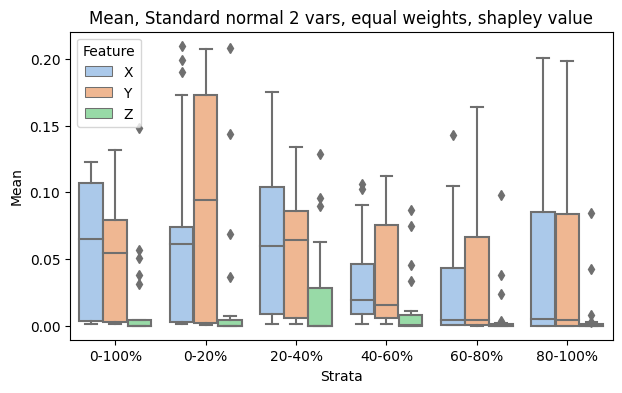

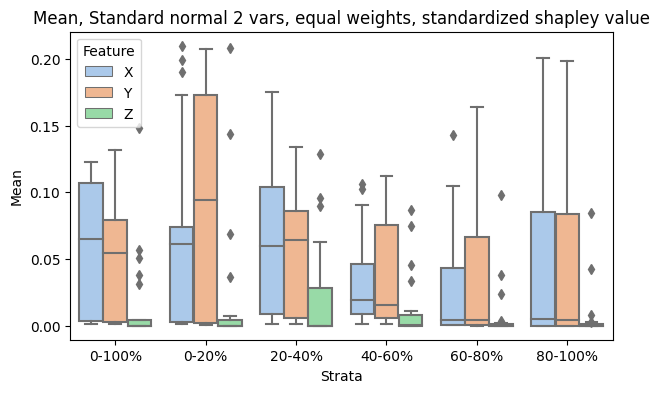

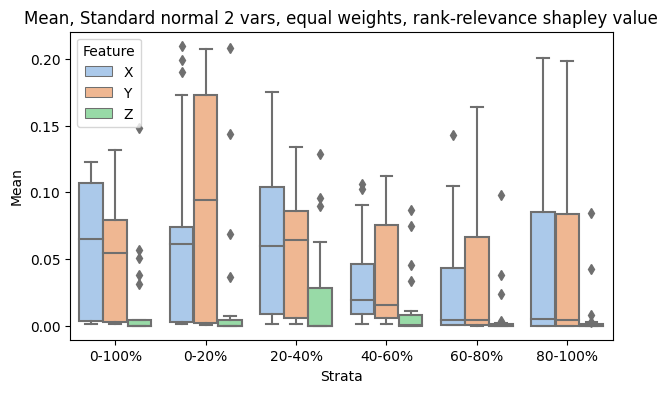

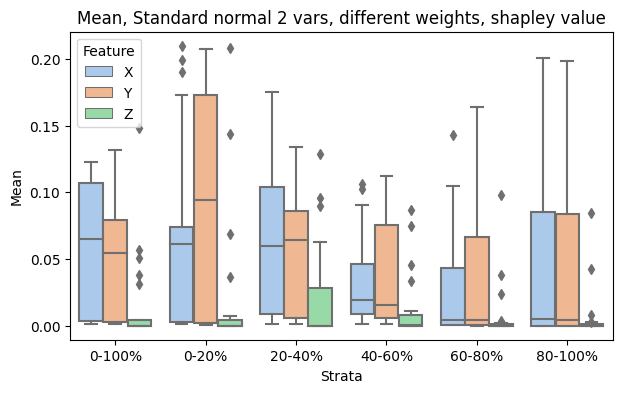

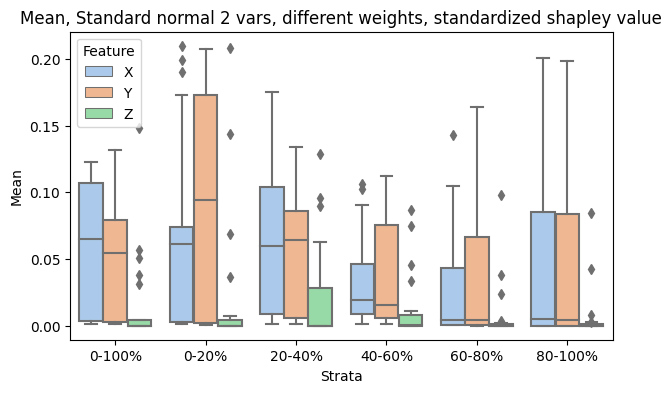

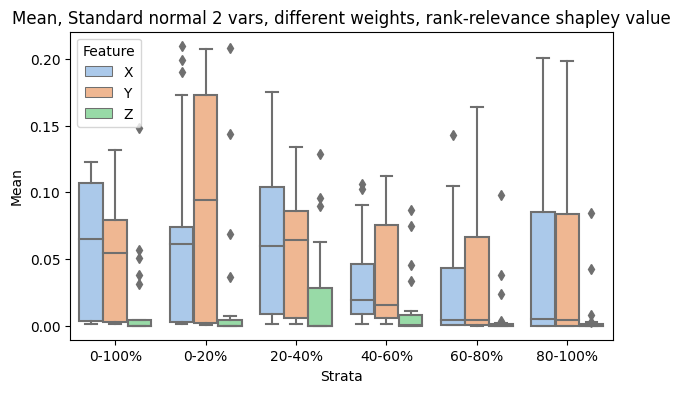

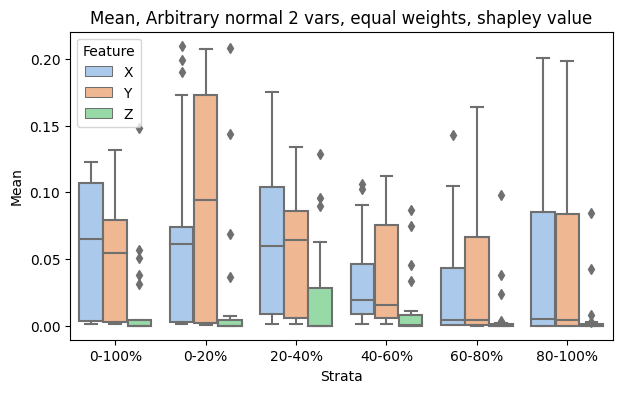

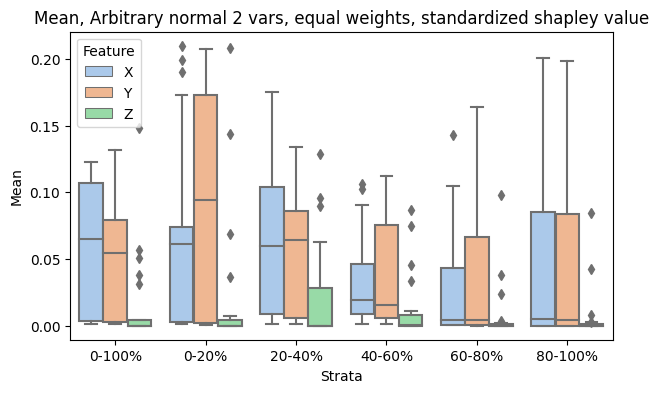

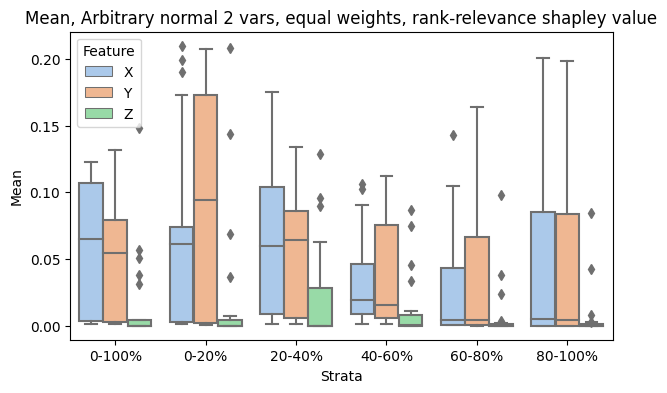

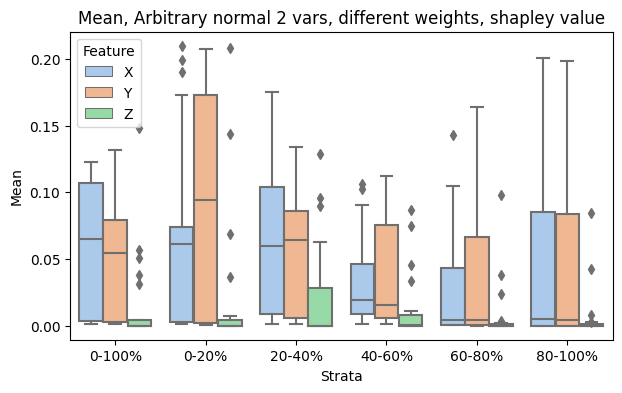

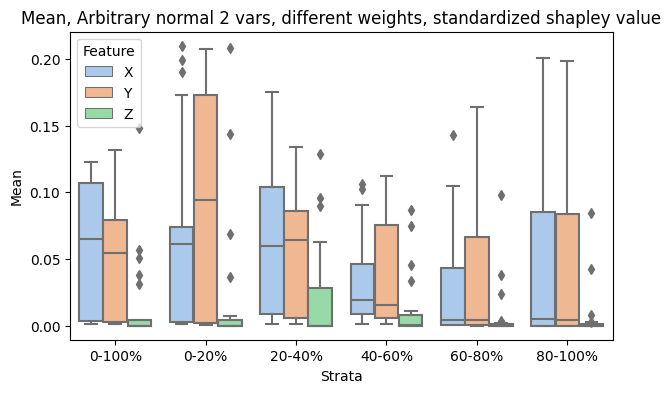

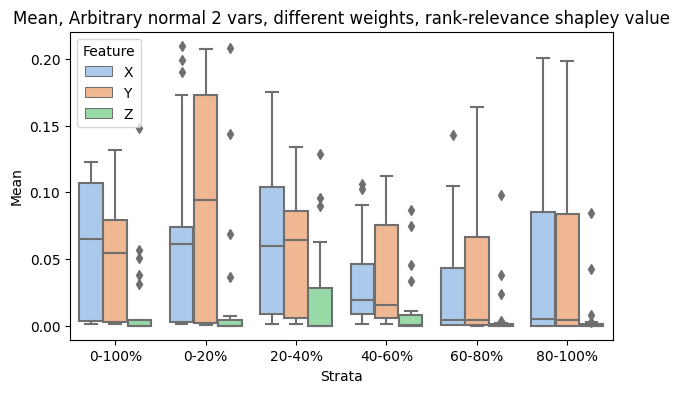

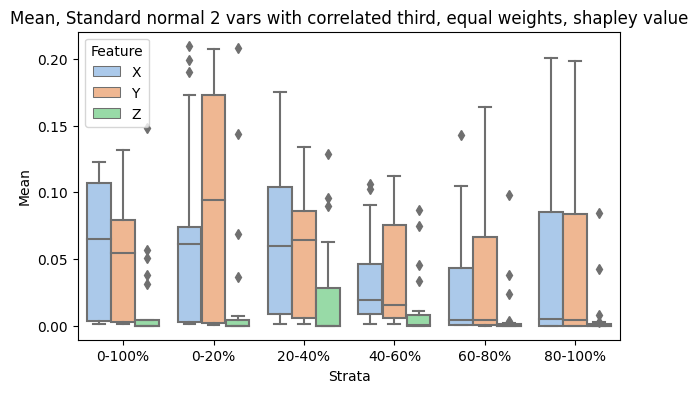

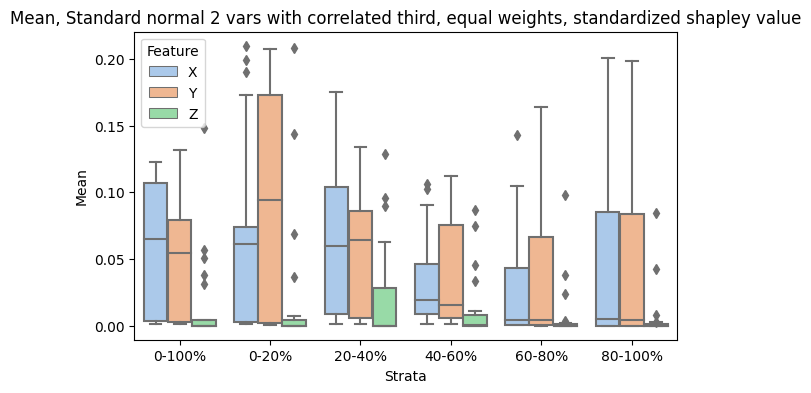

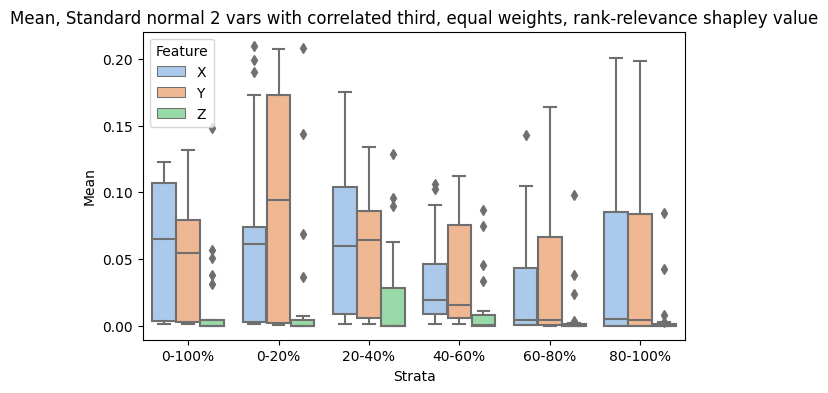

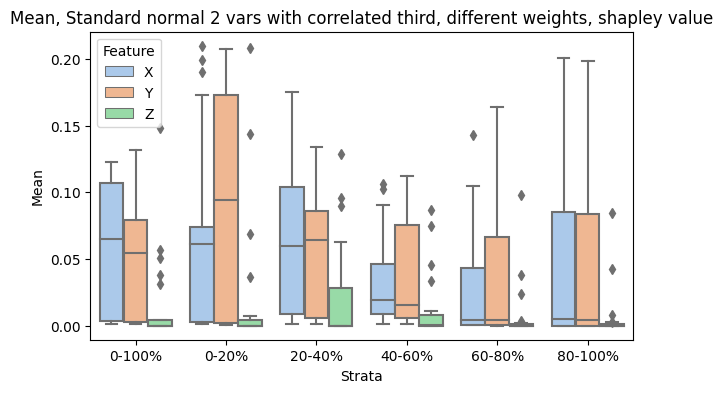

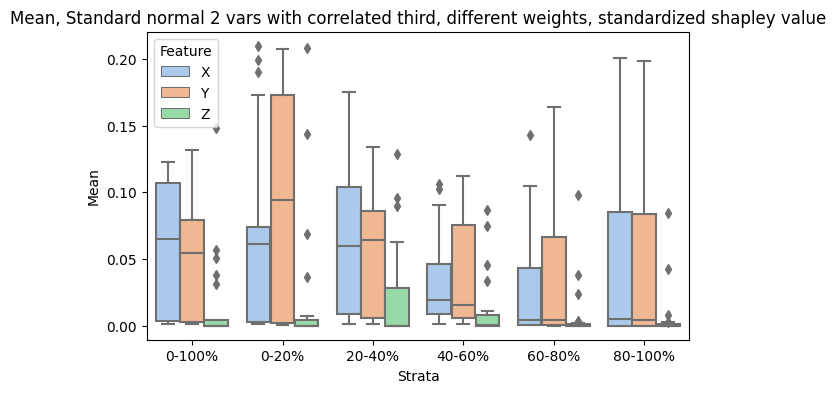

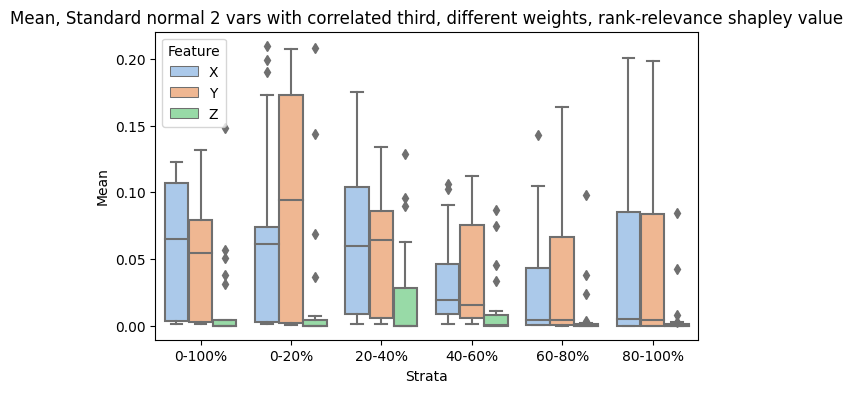

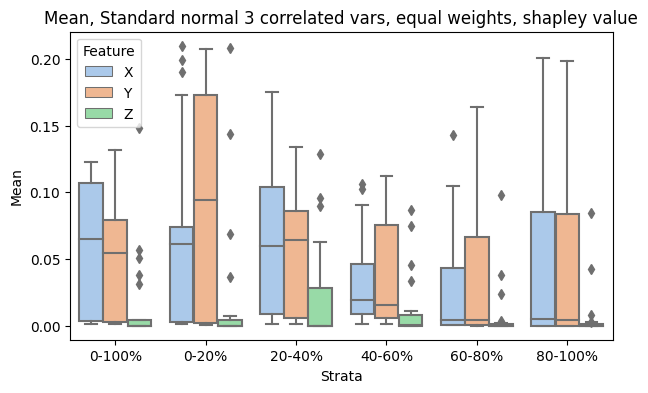

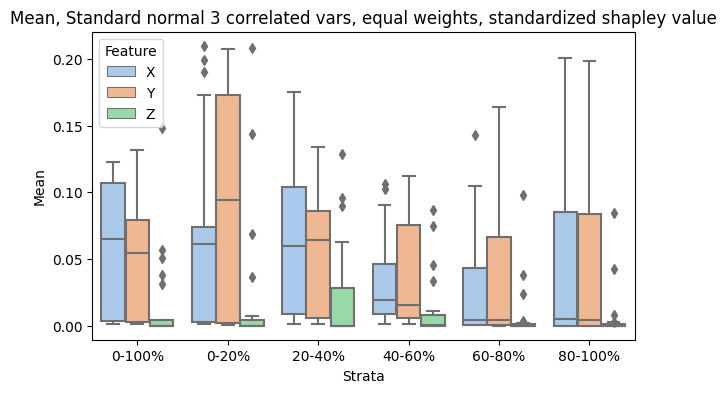

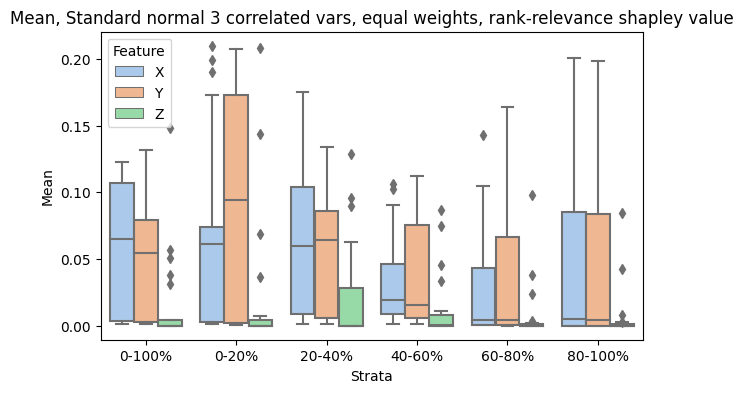

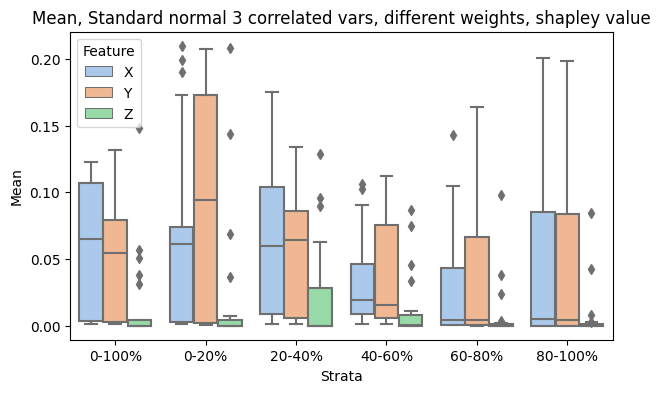

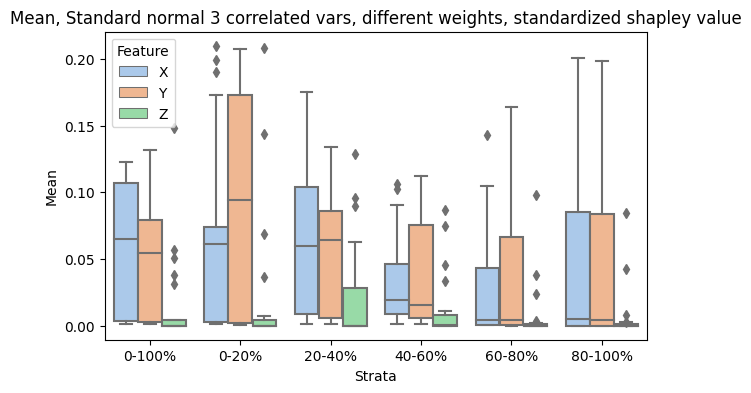

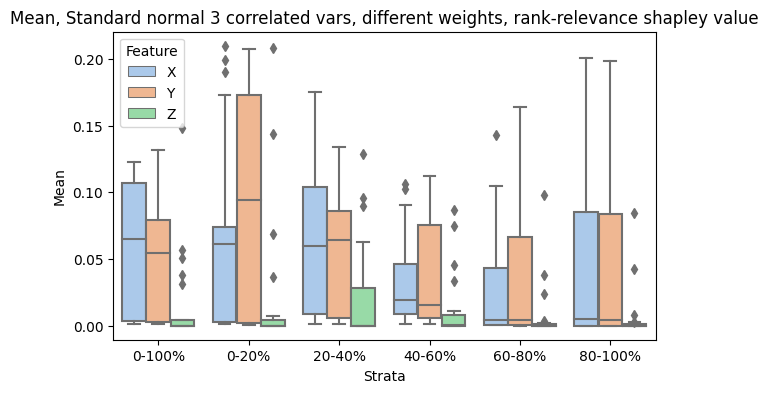

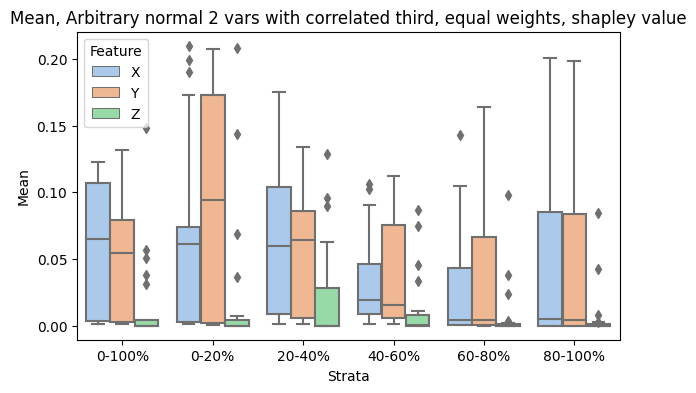

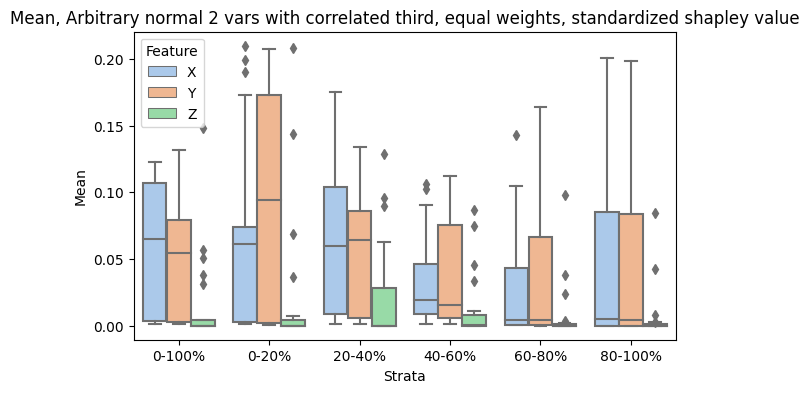

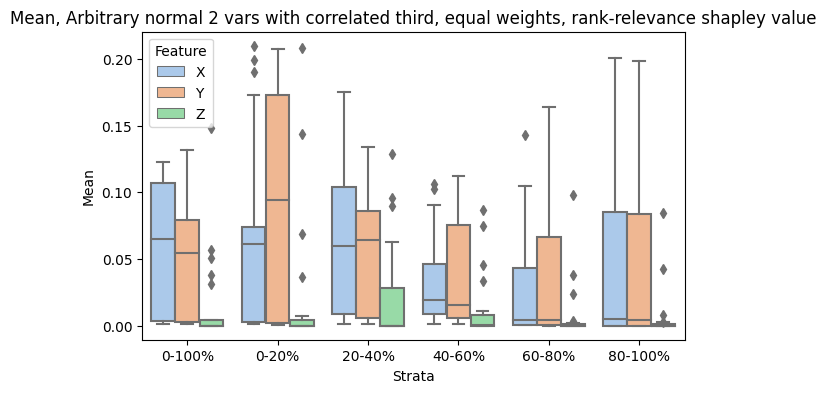

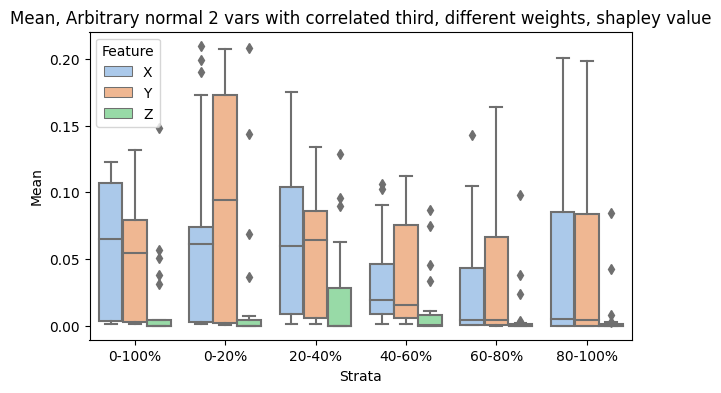

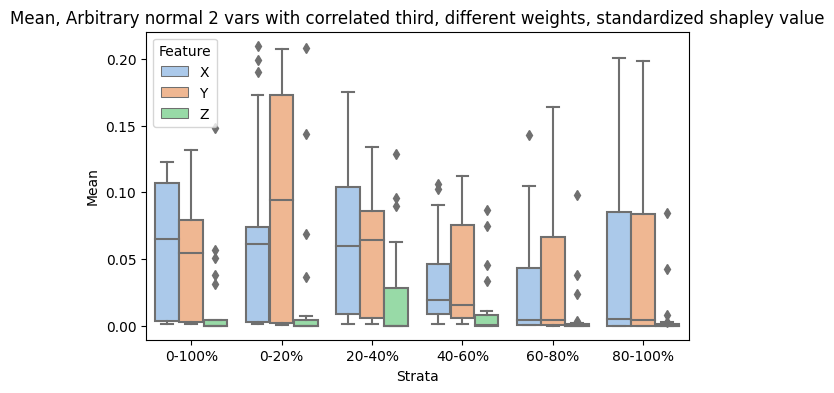

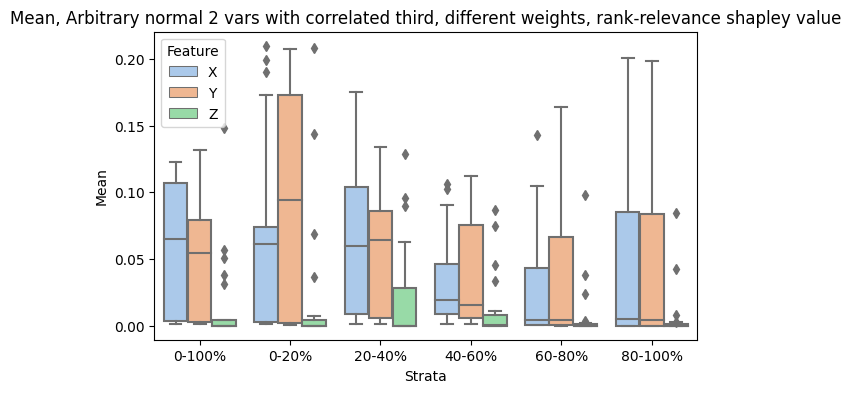

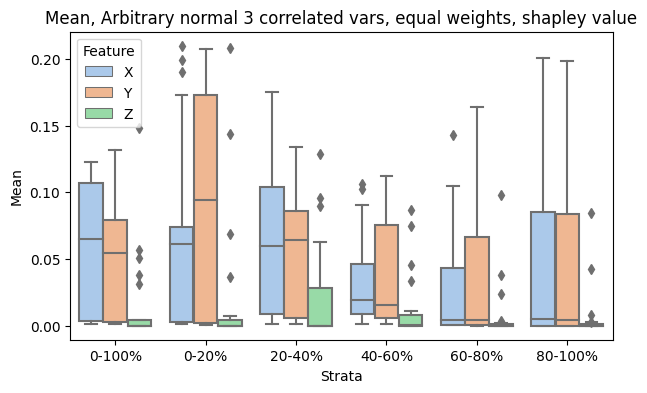

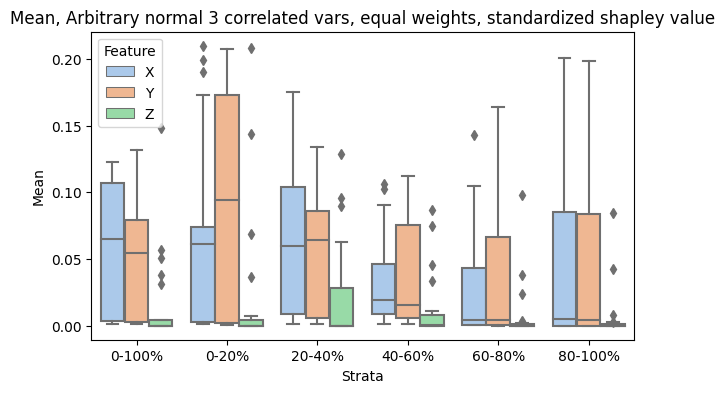

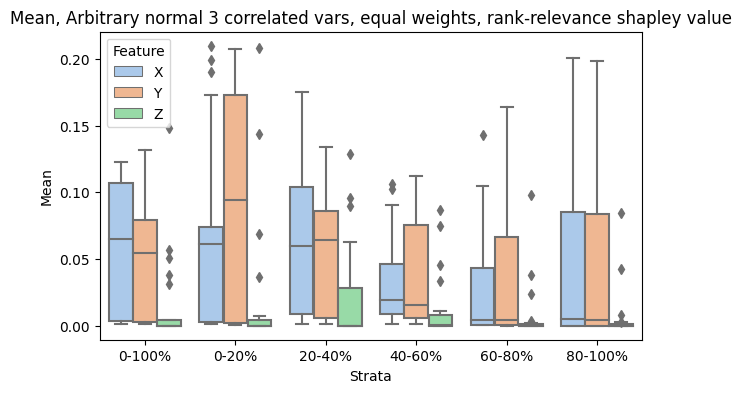

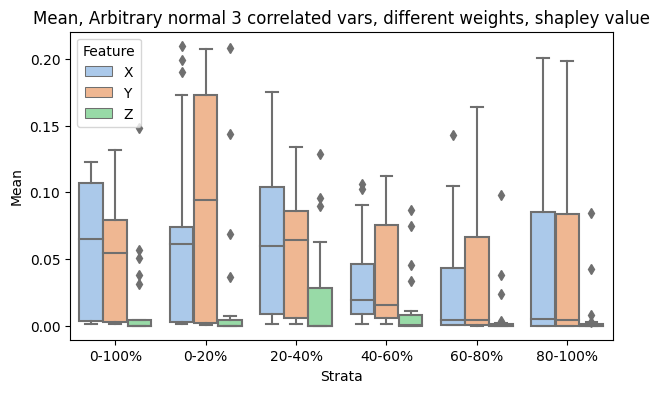

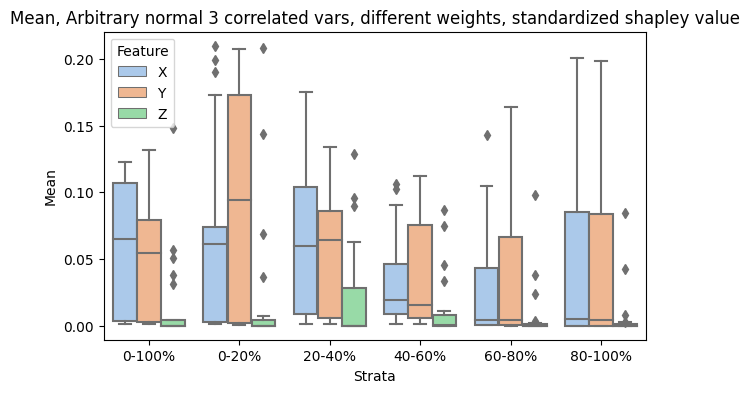

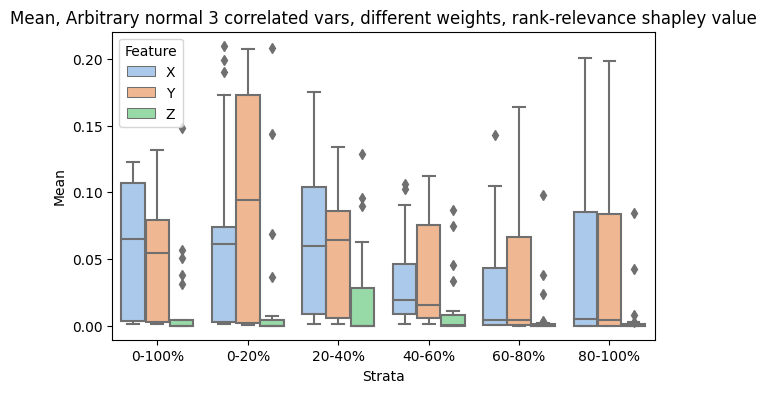

In [152]:
filtered_df = remove_outliers(results, 'mean')

for data in filtered_df['data'].unique():
    for weights in filtered_df['weights'].unique():
        for shapley_type in filtered_df['shapley_type'].unique():
            df = filtered_df[filtered_df['data'] == data]
            df = df[df['weights'] == weights]
            df = df[df['shapley_type'] == shapley_type]

            plt.figure(figsize=(7, 4))
            sns.boxplot(data=filtered_df, x='strata', y='mean', hue='feature', palette=color_palette)
            plt.title(f'Mean, {data}, {weights}, {shapley_type}')
            plt.xlabel('Strata')
            plt.ylabel('Mean')
            plt.legend(title='Feature')
plt.show()


# Compare feature contributions

## Inversions count for rankings

In [129]:
def inversions_count(arr1:list, arr2:list):
  indices = [arr1.index(x) for x in arr2]

  def merge_sort_inversions(arr):
    if len(arr) <= 1:
      return arr, 0
    else:
      a = arr[:len(arr)//2]
      b = arr[len(arr)//2:]
      a, ai = merge_sort_inversions(a)
      b, bi = merge_sort_inversions(b)
      c = []
      i = 0
      j = 0
      inversions = 0 + ai + bi
      while i < len(a) and j < len(b):
        if a[i] <= b[j]:
          c.append(a[i])
          i += 1
        else:
          c.append(b[j])
          j += 1
          inversions += (len(a)-i)
      c += a[i:]
      c += b[j:]
    return c, inversions
  n = len(indices)
  return merge_sort_inversions(indices)[1] / (n * (n-1)) *2